# Reviews classification

In this notebook, we will address the problem of text classification (movie reviews) and reproduce the CNN proposed by [Kim et al. (2014)](https://arxiv.org/pdf/1408.5882.pdf). A [follow-up work](https://arxiv.org/pdf/1510.03820.pdf) discusses the practical aspects.

Before starting, let's verify that we have a GPU available. If not, please change the runtime type **Runtime -> change runtime type -> hardware accelerator -> GPU**.

In [1]:
!nvidia-smi

Fri Jan  6 14:08:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    30W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Read and split data

Let's download the official dataset and see some examples

In [2]:
!rm rt-polaritydata*
!wget https://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz
!tar -xzvf rt-polaritydata.tar.gz
!mv rt-polaritydata/rt-polarity.neg neg_reviews.txt
!mv rt-polaritydata/rt-polarity.pos pos_reviews.txt

rm: cannot remove 'rt-polaritydata*': No such file or directory
--2023-01-06 14:08:55--  https://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 487770 (476K) [application/x-gzip]
Saving to: ‘rt-polaritydata.tar.gz’

rt-polaritydata.tar 100%[===================>] 476.34K   425KB/s    in 1.1s    

2023-01-06 14:08:57 (425 KB/s) - ‘rt-polaritydata.tar.gz’ saved [487770/487770]

rt-polaritydata.README.1.0.txt
rt-polaritydata/rt-polarity.neg
rt-polaritydata/rt-polarity.pos


In [3]:
!ls

neg_reviews.txt  rt-polaritydata		 rt-polaritydata.tar.gz
pos_reviews.txt  rt-polaritydata.README.1.0.txt  sample_data


In [4]:
reviews = {'pos': [],
           'neg': [],
           }

# Iterate over the dataset, tokenize and store the sentiment
for sentiment in reviews.keys():
  with open('{}_reviews.txt'.format(sentiment), 'r', encoding='latin-1') as fp:
    for line in fp:
      line = line.strip()
      if line != '':
        tokens = line.lower().split()
        reviews[sentiment].append(tokens)
  
  print(len(reviews[sentiment]), '{} reviews'.format(sentiment))
  print(reviews[sentiment][0])
  print(reviews[sentiment][1])
  print()

5331 pos reviews
['the', 'rock', 'is', 'destined', 'to', 'be', 'the', '21st', "century's", 'new', '"', 'conan', '"', 'and', 'that', "he's", 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'arnold', 'schwarzenegger', ',', 'jean-claud', 'van', 'damme', 'or', 'steven', 'segal', '.']
['the', 'gorgeously', 'elaborate', 'continuation', 'of', '"', 'the', 'lord', 'of', 'the', 'rings', '"', 'trilogy', 'is', 'so', 'huge', 'that', 'a', 'column', 'of', 'words', 'cannot', 'adequately', 'describe', 'co-writer/director', 'peter', "jackson's", 'expanded', 'vision', 'of', 'j', '.', 'r', '.', 'r', '.', "tolkien's", 'middle-earth', '.']

5331 neg reviews
['simplistic', ',', 'silly', 'and', 'tedious', '.']
["it's", 'so', 'laddish', 'and', 'juvenile', ',', 'only', 'teenage', 'boys', 'could', 'possibly', 'find', 'it', 'funny', '.']



The data is already preprocessed (e.g., tokenized), so there is no need for additional work. Let's prepare the label for each review. We assume that the label is binary where 1 means that the review is positive and 0 negative.

In [5]:
reviews_original = [{'tokens': review, 'sentiment':1, 'text': ' '.join(review)} for review in reviews['pos']] + \
                   [{'tokens': review, 'sentiment':0, 'text': ' '.join(review)} for review in reviews['neg']]
len(reviews_original)

10662

Before spliting the data into training, validation, and testing, it is a good practice to set all the random seeds for reproducibility purposes.

In [6]:
import numpy as np
import math
import random
import copy
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

In [7]:
# Set seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# We make a deep copy of the reviews and shuffle the data for the train, val, test split!
data = copy.deepcopy(reviews_original)
random.shuffle(data)

# We define how to split the data
split_train = int(len(data) * 0.8)
split_val = (len(data) - split_train) // 2
split_test = len(data) - split_train - split_val

train_data = data[:split_train]
data = data[split_train:]

val_data = data[:split_val]
data = data[split_val:]

test_data = data

# Sanity check
assert len(train_data + val_data + test_data) == len(reviews_original)
assert len(set((' '.join(sample['tokens']), sample['sentiment']) for sample in (train_data + val_data + test_data))) == len(reviews_original)

In [8]:
len(train_data), len(val_data), len(test_data) 

(8529, 1066, 1067)

In [9]:
len(reviews_original)

10662

# Build the vocabulary and word embedding matrix

We now have all our data. Let's build the vocabulary and prepare the word-embeddings for the next steps.

In [10]:
vocabulary = set()

for sample in train_data: # Pay attention we only use the training set!
  for token in sample['tokens']:
    vocabulary.add(token)
len(vocabulary)

19056

In this case, we do not have too many words so there is no need to filter/reduce the vocabulary (< 30k is usually good enough). Typically, we could use a frequency approach and removes words appearing less than X times.

In [11]:
# Create the mappindg word - index and vice-versa
word2idx = {'_PAD_': 0, '_UNK_': 1}
for word in vocabulary:
  word2idx[word] = len(word2idx)
idx2word = {idx:word for word, idx in word2idx.items()}
word2idx

{'_PAD_': 0,
 '_UNK_': 1,
 'saps': 2,
 "whitaker's": 3,
 "'moore": 4,
 'adrenalin': 5,
 'delayed': 6,
 'solo': 7,
 'self-inflicted': 8,
 'estranhos': 9,
 'tells': 10,
 'greenfingers': 11,
 'well-thought': 12,
 'muting': 13,
 'torpor': 14,
 'integrates': 15,
 'drowned': 16,
 'soil': 17,
 'moonlight': 18,
 'outage': 19,
 'moisture': 20,
 'improvisation': 21,
 "'thank": 22,
 'kids-in-peril': 23,
 'collinwood': 24,
 'across': 25,
 'academic': 26,
 'submerged': 27,
 'lean': 28,
 'unappealing': 29,
 'deathly': 30,
 'uncanny': 31,
 'dullest': 32,
 'pain': 33,
 'adequate': 34,
 'profiling': 35,
 'forefront': 36,
 'thank': 37,
 'only-in': 38,
 'cares': 39,
 'belittle': 40,
 'flog': 41,
 'leanest': 42,
 'location': 43,
 'jammies': 44,
 'fire-breathing': 45,
 'ego': 46,
 'appetite': 47,
 '2': 48,
 '80-minute': 49,
 '[taylor]': 50,
 'kiarostami': 51,
 'enervating': 52,
 'ambivalence': 53,
 'elderly': 54,
 'assured': 55,
 'irreconcilable': 56,
 'heart-breakingly': 57,
 'indians': 58,
 'salvaged': 5

In [12]:
idx2word

{0: '_PAD_',
 1: '_UNK_',
 2: 'saps',
 3: "whitaker's",
 4: "'moore",
 5: 'adrenalin',
 6: 'delayed',
 7: 'solo',
 8: 'self-inflicted',
 9: 'estranhos',
 10: 'tells',
 11: 'greenfingers',
 12: 'well-thought',
 13: 'muting',
 14: 'torpor',
 15: 'integrates',
 16: 'drowned',
 17: 'soil',
 18: 'moonlight',
 19: 'outage',
 20: 'moisture',
 21: 'improvisation',
 22: "'thank",
 23: 'kids-in-peril',
 24: 'collinwood',
 25: 'across',
 26: 'academic',
 27: 'submerged',
 28: 'lean',
 29: 'unappealing',
 30: 'deathly',
 31: 'uncanny',
 32: 'dullest',
 33: 'pain',
 34: 'adequate',
 35: 'profiling',
 36: 'forefront',
 37: 'thank',
 38: 'only-in',
 39: 'cares',
 40: 'belittle',
 41: 'flog',
 42: 'leanest',
 43: 'location',
 44: 'jammies',
 45: 'fire-breathing',
 46: 'ego',
 47: 'appetite',
 48: '2',
 49: '80-minute',
 50: '[taylor]',
 51: 'kiarostami',
 52: 'enervating',
 53: 'ambivalence',
 54: 'elderly',
 55: 'assured',
 56: 'irreconcilable',
 57: 'heart-breakingly',
 58: 'indians',
 59: 'salvaged

In [38]:
idx2word[900]

','

In [13]:
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2023-01-06 14:18:45--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-01-06 14:18:45--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  1.35MB/s    in 5m 6s   

2023-01-06 14:23:53 (2.68 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflatin

In [14]:
# Easier to load with gensim
WORD_DIM = 300
from gensim.models import KeyedVectors
#word2vec = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

# Glove
from gensim.scripts.glove2word2vec import glove2word2vec
_ = glove2word2vec('glove.6B.300d.txt', 'glove.6B.300d_w2v.txt')
word2vec = KeyedVectors.load_word2vec_format('glove.6B.300d_w2v.txt', binary=False)

In [15]:
# Now we create the word embedding matrix and copy from word2vec embeddings!

# Initialize randomly the word embedding matrix
word_embeddings = np.random.rand(len(word2idx), WORD_DIM)

# Set the values to 0 for padding
word_embeddings[word2idx['_PAD_']] = np.zeros(WORD_DIM)

# Copy from word2vec
for word in vocabulary:
  if word in word2vec:
    word_embeddings[word2idx[word], :] = word2vec[word]
word_embeddings.shape

(19058, 300)

# Process the data.

Now, we can add the word embedding indeces to our data to be fed to the model. Let's see what is there so far.

In [26]:
train_data[3]

{'tokens': ["it's",
  'easy',
  'to',
  'love',
  'robin',
  'tunney',
  '--',
  "she's",
  'pretty',
  'and',
  'she',
  'can',
  'act',
  '--',
  'but',
  'it',
  'gets',
  'harder',
  'and',
  'harder',
  'to',
  'understand',
  'her',
  'choices',
  '.'],
 'sentiment': 0,
 'text': "it's easy to love robin tunney -- she's pretty and she can act -- but it gets harder and harder to understand her choices .",
 'word_idx': [9199,
  4534,
  17039,
  18460,
  7728,
  11926,
  1770,
  12298,
  9763,
  7590,
  7447,
  18997,
  14321,
  1770,
  11382,
  7519,
  8226,
  10111,
  7590,
  10111,
  17039,
  11069,
  3628,
  14996,
  12850,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

Good. Let's add an attribute `word_idx` to all samples. In case a word is unknown, we will simply replace it with the work "_UNK_".

In [19]:
# We add the word indeces to all data splits
for split_data in [train_data, val_data, test_data]:
  for sample in split_data:
    sample['word_idx'] = []
    for token in sample['tokens']:
      # If a word is not in our vocabulary, we put the UNK token instead
      sample['word_idx'].append(word2idx[token] if token in word2idx else word2idx['_UNK_'])

Great! We are nearly there. The last problem to address is to have the same length for the reviews. A simple way is to pad each sample until reaching the maximum length.

Let's see what is the longest review so far.

In [20]:
max(len(sample['tokens']) for sample in train_data), \
max(len(sample['tokens']) for sample in val_data), \
max(len(sample['tokens']) for sample in test_data)

(59, 51, 51)

Now, the last step is to pad all reviews to 59 tokens!

In [24]:
PAD_LENGTH = 59

for split_data in [train_data, val_data, test_data]:
  for sample in split_data:
    while len(sample['word_idx']) < PAD_LENGTH:
      sample['word_idx'].append(word2idx['_PAD_'])
    
    # Sanity check
    assert len(sample['word_idx']) == PAD_LENGTH

In [35]:
train_data[0]

{'tokens': ['chicago',
  'is',
  ',',
  'in',
  'many',
  'ways',
  ',',
  'an',
  'admirable',
  'achievement',
  '.'],
 'sentiment': 1,
 'text': 'chicago is , in many ways , an admirable achievement .',
 'word_idx': [5027,
  11323,
  900,
  17980,
  3882,
  2547,
  900,
  14694,
  12828,
  8667,
  12850,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

# Modeling

Now we can start designing our model. In Kim et al. 2014, the authors proposed the following one: 

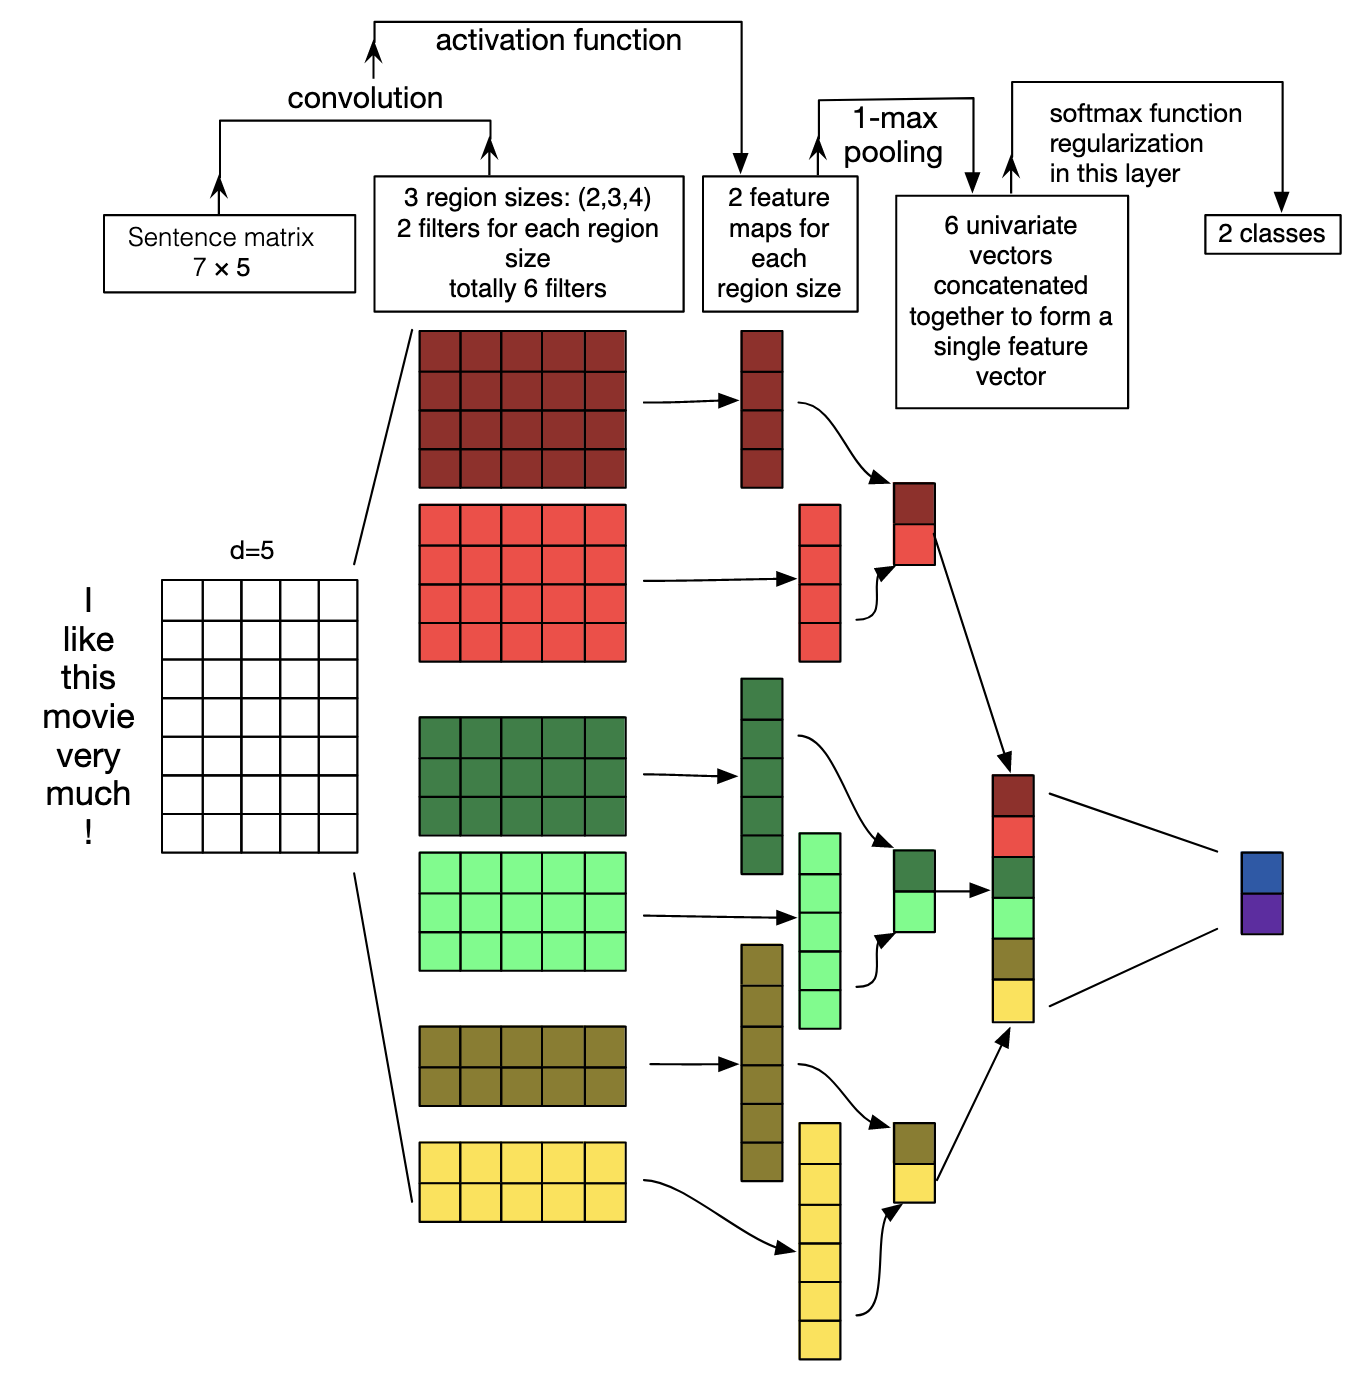

For the details, we will implement the "CNN-static" model:
- Static word embedding from word2vec with 300 dimensions (not fine-tuned)
- 100 filters/kernel/features map for each window size of 3,4,5 (i.e., n-grams)
- Max pooling to reduce the size followed by a projection layer to the output
- Dropout of 50%
- L2 weight

In [39]:
class CNN(nn.Module):
    def __init__(self, input_size, dropout, filter_num, classes_num, words_num):
        super(CNN, self).__init__()

        self.embedding = nn.Embedding(num_embeddings=words_num, embedding_dim=input_size)

        # We create the convolution layers
        self.conv_3 = nn.Conv1d(in_channels=input_size, out_channels=filter_num, kernel_size=3)
        self.conv_4 = nn.Conv1d(in_channels=input_size, out_channels=filter_num, kernel_size=4)
        self.conv_5 = nn.Conv1d(in_channels=input_size, out_channels=filter_num, kernel_size=5)       
        self.convs = [(self.conv_3, 3), 
                      (self.conv_4, 4),
                      (self.conv_5, 5),
                      ]

        self.dropout = nn.Dropout(dropout)
        self.activation = nn.Tanh()

        # The last layer to compute the probabilities for the output classes
        self.final_layer = nn.Linear(in_features=len(self.convs) * filter_num, out_features=classes_num)
        
    def forward(self, x):
        x = self.embedding(x) # Convert into word embeddings
        x = torch.transpose(x, 1, 2) # Switch X to (Batch, Embed, Length) --> CF Doc https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html?highlight=conv1d#torch.nn.Conv1d
        x = self.dropout(x)

        output = []
        for conv, kernel_size in self.convs:
            # To have consistent dimension output, we always pad the input
            padded_activ = F.pad(x, pad=(kernel_size - 1, 0), mode='constant', value=0) #BxDx(L+K-1)

            # We do the convolution followed by an activation function
            result = self.activation(conv(padded_activ))

            # We max-pool
            result = F.max_pool1d(result, result.size(2)).squeeze(-1) #BxD
            
            # We store the result and move to the next convolution
            output.append(result)

        # concat across channels -> 3 x result.size(2)
        output = torch.cat(output, 1)
        output = self.dropout(output)
        
        # Compute the log probabilities. We do not compute the probabilities with Softmax because depending the loss function, we might require unnormalized or probabilities.
        # Worst case, we can always apply F.softmax(output, dim=-1) later.
        logits = self.final_layer(output)
        return logits

Let's see if our model can compute a foward pass

In [40]:
# Example of a batch=1 and 6 word indeces
input = torch.tensor([[0,1,2,3,4,5]])
input

tensor([[0, 1, 2, 3, 4, 5]])

In [41]:
cnn = CNN(input_size=300, dropout=0.5, filter_num=100, classes_num=2, words_num=6)
logits = cnn(input)
F.softmax(logits, dim=-1)

tensor([[0.4311, 0.5689]], grad_fn=<SoftmaxBackward0>)

Great! The model seems to work and is able to compute the sentiment probability of a document.

# Loss function

What is the loss to use to optimize the model? Because we are doing binary text classification, the most natural one is to use the [cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html?highlight=cross%20entropy#torch.nn.CrossEntropyLoss). Let's see some examples

In [42]:
criterion = nn.CrossEntropyLoss(reduction='none')

If you lookt at the documentation, it is written that CrossEntropyLoss takes as input **unnormalized** data! (i.e., NOT probabilities).

Let's see what happens if we feed directly probabilities

In [43]:
pred = torch.tensor([[0.0, 1.0], [0.25, 0.75], [0.5, 0.5], [0.75, 0.25], [0.99, 0.01]]) # Assumed this has been computed by a model
gold = torch.tensor([ 1       ,   1          , 1         ,  1          ,  1]) # The targets: everything must be positive
F.cross_entropy(pred, gold, reduction='none')

tensor([0.3133, 0.4741, 0.6931, 0.9741, 1.2987])

We note that the loss is not 0 when the prediction is correct but 0.3133! However, if we "unnormalize" the data (solely for illustration purposes), we observe that the results make sense

In [44]:
def inv_softmax(x):
  return x.log() + math.log(10.)

pred = inv_softmax(torch.tensor([[0.0, 1.0], [0.25, 0.75], [0.5, 0.5], [0.75, 0.25], [0.99, 0.01]])) # Assumed this has been computed by a model
gold = torch.tensor([ 1       ,   1          , 1         ,  1          ,  1]) # The target: everything must be positive
F.cross_entropy(pred, gold, reduction='none')

tensor([-0.0000, 0.2877, 0.6931, 1.3863, 4.6052])

Indeed, when the prediction is correct, we obtain a loss of 0! and In the worst case, a loss of 4.6.

# Metric

As our task implies binary classification and the distribution of data is balanced originally, we can assume accuracy is a good enough metric.

In [45]:
from sklearn.metrics import accuracy_score
def compute_accuracy(preds, golds):
  return accuracy_score(preds, golds)

# Putting all together

We now have the model, the data, and the loss function. We are ready to implement the training loop.

In [46]:
# We initialize our model
model = CNN(input_size=300, dropout=0.5, filter_num=100, classes_num=2, words_num=len(word2idx))

# Copy the word embedding matrix
model.embedding.weight.data = torch.from_numpy(word_embeddings).float()
model.embedding.weight.requires_grad = False # We do NOT want to fine-tune the word embedding

In [47]:
# We initialize our optimizer to update the weights of the model
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-8) # L2 = weight_decay

In [53]:
BATCH_SIZE = 125

# Move the model to the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Initialize the loss function
criterion = nn.CrossEntropyLoss(reduction='mean')

best_epoch = 0
best_val_so_far = 0
test_perf = 0

# TRAINING LOOP
for epoch in range(150):
  print('------------------------------------------------------------------------')
  print('Epoch: {}'.format(epoch))

  # TRAIN
  # We set the model in train mode. It will store information to compute the gradients
  # Also, the implementation of dropout, batchnorm, etc is different at training and inference time.
  model.train()

  train_losses = []
  for idx in tqdm.tqdm(range(0, len(train_data), BATCH_SIZE), desc='Training'):
    samples = train_data[idx:idx+BATCH_SIZE]

    # Create tensors for the data and move them to GPU
    X = [sample['word_idx'] for sample in samples]
    y = [sample['sentiment'] for sample in samples]
    X = torch.tensor(X).long().to(device)
    y = torch.tensor(y).long().to(device)

    # Compute the model output and the loss
    y_logits = model(X)
    loss = criterion(y_logits, y)

    # Update model parameters
    optimizer.zero_grad() # This is very important! By default, gradients are cumulated in tensors.
    loss.backward() # Now that gradients have been empties, we compute the new ones using the loss.
    optimizer.step() # We do gradient update with our optimization function (i.e., the weights of the model are updated).
  
    train_losses.append(loss.item())
  
  
  # VAL + TEST
  val_test_losses = {'val': [], 'test': []}
  val_test_accuracy = {'val': [], 'test': []}
  
  # Unlike before, we set the model in eval mode to compute correctly dropout, batchnorm etc
  model.eval()

  # We do not store information relative to gradients as we do not update the model.
  # That's the reason why inference requires less memory and is faster.
  with torch.no_grad():
    for split_data, data in [('val', val_data), ('test', test_data)]:
      for idx in tqdm.tqdm(range(0, len(data), BATCH_SIZE), desc=split_data.capitalize()):
        samples = data[idx:idx+BATCH_SIZE]

        # Create tensors for the data and move them to GPU
        X = [sample['word_idx'] for sample in samples]
        y_gold = [sample['sentiment'] for sample in samples]
        X = torch.tensor(X).long().to(device)
        y = torch.tensor(y_gold).long().to(device)

        # Compute the model output, the probabilities, and the loss
        y_logits = model(X)
        y_probs = F.softmax(y_logits, dim=-1)
        y_pred = torch.argmax(y_logits, dim=-1)

        loss = criterion(y_logits, y)
        val_test_losses[split_data].append(loss.item())

        # Compute the accuracy to evaluate our model
        accuracy = compute_accuracy(y_pred.cpu().numpy(), y_gold)
        val_test_accuracy[split_data].append(accuracy)
  
  # Monitoring
  print('Train loss: {:.4f}'.format(np.mean(train_losses)))
  print('Val   loss: {:.4f}'.format(np.mean(val_test_losses['val'])))
  print('Test  loss: {:.4f}'.format(np.mean(val_test_losses['test'])))
  print()

  val_acc = np.mean(val_test_accuracy['val'])
  test_acc = np.mean(val_test_accuracy['test'])
  print('Val   Acc: {:.4f}'.format(val_acc))
  print('Test  Acc: {:.4f}'.format(test_acc))
  print()

  if best_val_so_far < val_acc:
    best_val_so_far = val_acc
    test_perf = test_acc
    best_epoch = epoch
  
  print('Best Epoch: {}, best val accuracy: {:.4f}, test accuracy: {:.4f}'.format(best_epoch, best_val_so_far, test_perf))
  print()
  print()

------------------------------------------------------------------------
Epoch: 0


Test: 100%|██████████| 9/9 [00:00<00:00, 358.24it/s]


Train loss: 0.0816
Val   loss: 0.6013
Test  loss: 0.6591

Val   Acc: 0.7796
Test  Acc: 0.7828

Best Epoch: 0, best val accuracy: 0.7796, test accuracy: 0.7828


------------------------------------------------------------------------
Epoch: 1


Test: 100%|██████████| 9/9 [00:00<00:00, 355.85it/s]


Train loss: 0.0891
Val   loss: 0.5968
Test  loss: 0.6564

Val   Acc: 0.7841
Test  Acc: 0.7819

Best Epoch: 1, best val accuracy: 0.7841, test accuracy: 0.7819


------------------------------------------------------------------------
Epoch: 2


Test: 100%|██████████| 9/9 [00:00<00:00, 366.60it/s]


Train loss: 0.0841
Val   loss: 0.6029
Test  loss: 0.6570

Val   Acc: 0.7929
Test  Acc: 0.7863

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 3


Test: 100%|██████████| 9/9 [00:00<00:00, 325.41it/s]


Train loss: 0.0764
Val   loss: 0.6027
Test  loss: 0.6560

Val   Acc: 0.7814
Test  Acc: 0.7817

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 4


Test: 100%|██████████| 9/9 [00:00<00:00, 331.64it/s]


Train loss: 0.0862
Val   loss: 0.6027
Test  loss: 0.6577

Val   Acc: 0.7841
Test  Acc: 0.7775

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 5


Test: 100%|██████████| 9/9 [00:00<00:00, 343.65it/s]


Train loss: 0.0865
Val   loss: 0.6043
Test  loss: 0.6577

Val   Acc: 0.7814
Test  Acc: 0.7802

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 6


Test: 100%|██████████| 9/9 [00:00<00:00, 349.71it/s]


Train loss: 0.0804
Val   loss: 0.6019
Test  loss: 0.6616

Val   Acc: 0.7814
Test  Acc: 0.7783

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 7


Test: 100%|██████████| 9/9 [00:00<00:00, 365.14it/s]


Train loss: 0.0821
Val   loss: 0.6045
Test  loss: 0.6658

Val   Acc: 0.7805
Test  Acc: 0.7766

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 8


Test: 100%|██████████| 9/9 [00:00<00:00, 327.91it/s]


Train loss: 0.0811
Val   loss: 0.6011
Test  loss: 0.6623

Val   Acc: 0.7875
Test  Acc: 0.7783

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 9


Test: 100%|██████████| 9/9 [00:00<00:00, 334.82it/s]


Train loss: 0.0760
Val   loss: 0.6044
Test  loss: 0.6654

Val   Acc: 0.7849
Test  Acc: 0.7800

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 10


Test: 100%|██████████| 9/9 [00:00<00:00, 332.57it/s]


Train loss: 0.0807
Val   loss: 0.6050
Test  loss: 0.6629

Val   Acc: 0.7840
Test  Acc: 0.7767

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 11


Test: 100%|██████████| 9/9 [00:00<00:00, 341.59it/s]


Train loss: 0.0848
Val   loss: 0.6068
Test  loss: 0.6592

Val   Acc: 0.7814
Test  Acc: 0.7818

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 12


Test: 100%|██████████| 9/9 [00:00<00:00, 343.08it/s]


Train loss: 0.0741
Val   loss: 0.6069
Test  loss: 0.6590

Val   Acc: 0.7805
Test  Acc: 0.7870

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 13


Test: 100%|██████████| 9/9 [00:00<00:00, 331.84it/s]


Train loss: 0.0890
Val   loss: 0.6107
Test  loss: 0.6650

Val   Acc: 0.7832
Test  Acc: 0.7819

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 14


Test: 100%|██████████| 9/9 [00:00<00:00, 332.96it/s]


Train loss: 0.0758
Val   loss: 0.6096
Test  loss: 0.6638

Val   Acc: 0.7832
Test  Acc: 0.7845

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 15


Test: 100%|██████████| 9/9 [00:00<00:00, 271.43it/s]


Train loss: 0.0782
Val   loss: 0.6115
Test  loss: 0.6616

Val   Acc: 0.7832
Test  Acc: 0.7790

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 16


Test: 100%|██████████| 9/9 [00:00<00:00, 342.44it/s]


Train loss: 0.0731
Val   loss: 0.6101
Test  loss: 0.6625

Val   Acc: 0.7841
Test  Acc: 0.7844

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 17


Test: 100%|██████████| 9/9 [00:00<00:00, 299.85it/s]


Train loss: 0.0861
Val   loss: 0.6075
Test  loss: 0.6610

Val   Acc: 0.7883
Test  Acc: 0.7837

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 18


Test: 100%|██████████| 9/9 [00:00<00:00, 339.96it/s]


Train loss: 0.0821
Val   loss: 0.6080
Test  loss: 0.6604

Val   Acc: 0.7850
Test  Acc: 0.7845

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 19


Test: 100%|██████████| 9/9 [00:00<00:00, 310.09it/s]


Train loss: 0.0773
Val   loss: 0.6094
Test  loss: 0.6624

Val   Acc: 0.7866
Test  Acc: 0.7889

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 20


Test: 100%|██████████| 9/9 [00:00<00:00, 282.87it/s]


Train loss: 0.0774
Val   loss: 0.6115
Test  loss: 0.6635

Val   Acc: 0.7815
Test  Acc: 0.7872

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 21


Test: 100%|██████████| 9/9 [00:00<00:00, 355.54it/s]


Train loss: 0.0813
Val   loss: 0.6059
Test  loss: 0.6595

Val   Acc: 0.7832
Test  Acc: 0.7828

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 22


Test: 100%|██████████| 9/9 [00:00<00:00, 361.98it/s]


Train loss: 0.0812
Val   loss: 0.6107
Test  loss: 0.6603

Val   Acc: 0.7857
Test  Acc: 0.7846

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 23


Test: 100%|██████████| 9/9 [00:00<00:00, 342.82it/s]


Train loss: 0.0753
Val   loss: 0.6123
Test  loss: 0.6619

Val   Acc: 0.7848
Test  Acc: 0.7888

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 24


Test: 100%|██████████| 9/9 [00:00<00:00, 360.62it/s]


Train loss: 0.0753
Val   loss: 0.6103
Test  loss: 0.6621

Val   Acc: 0.7822
Test  Acc: 0.7863

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 25


Test: 100%|██████████| 9/9 [00:00<00:00, 376.22it/s]


Train loss: 0.0876
Val   loss: 0.6131
Test  loss: 0.6623

Val   Acc: 0.7832
Test  Acc: 0.7880

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 26


Test: 100%|██████████| 9/9 [00:00<00:00, 336.03it/s]


Train loss: 0.0800
Val   loss: 0.6148
Test  loss: 0.6625

Val   Acc: 0.7823
Test  Acc: 0.7837

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 27


Test: 100%|██████████| 9/9 [00:00<00:00, 242.26it/s]


Train loss: 0.0784
Val   loss: 0.6193
Test  loss: 0.6674

Val   Acc: 0.7805
Test  Acc: 0.7828

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 28


Test: 100%|██████████| 9/9 [00:00<00:00, 346.61it/s]


Train loss: 0.0798
Val   loss: 0.6222
Test  loss: 0.6678

Val   Acc: 0.7787
Test  Acc: 0.7836

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 29


Test: 100%|██████████| 9/9 [00:00<00:00, 332.68it/s]


Train loss: 0.0806
Val   loss: 0.6175
Test  loss: 0.6628

Val   Acc: 0.7787
Test  Acc: 0.7836

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 30


Test: 100%|██████████| 9/9 [00:00<00:00, 327.29it/s]


Train loss: 0.0823
Val   loss: 0.6248
Test  loss: 0.6678

Val   Acc: 0.7805
Test  Acc: 0.7793

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 31


Test: 100%|██████████| 9/9 [00:00<00:00, 344.99it/s]


Train loss: 0.0822
Val   loss: 0.6181
Test  loss: 0.6618

Val   Acc: 0.7787
Test  Acc: 0.7863

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 32


Test: 100%|██████████| 9/9 [00:00<00:00, 329.21it/s]


Train loss: 0.0771
Val   loss: 0.6213
Test  loss: 0.6655

Val   Acc: 0.7796
Test  Acc: 0.7888

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 33


Test: 100%|██████████| 9/9 [00:00<00:00, 305.29it/s]


Train loss: 0.0769
Val   loss: 0.6157
Test  loss: 0.6613

Val   Acc: 0.7867
Test  Acc: 0.7835

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 34


Test: 100%|██████████| 9/9 [00:00<00:00, 310.32it/s]


Train loss: 0.0758
Val   loss: 0.6149
Test  loss: 0.6590

Val   Acc: 0.7805
Test  Acc: 0.7853

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 35


Test: 100%|██████████| 9/9 [00:00<00:00, 357.67it/s]


Train loss: 0.0822
Val   loss: 0.6129
Test  loss: 0.6572

Val   Acc: 0.7867
Test  Acc: 0.7836

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 36


Test: 100%|██████████| 9/9 [00:00<00:00, 335.39it/s]


Train loss: 0.0812
Val   loss: 0.6163
Test  loss: 0.6585

Val   Acc: 0.7824
Test  Acc: 0.7767

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 37


Test: 100%|██████████| 9/9 [00:00<00:00, 337.70it/s]


Train loss: 0.0788
Val   loss: 0.6190
Test  loss: 0.6552

Val   Acc: 0.7894
Test  Acc: 0.7809

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 38


Test: 100%|██████████| 9/9 [00:00<00:00, 325.77it/s]


Train loss: 0.0752
Val   loss: 0.6165
Test  loss: 0.6558

Val   Acc: 0.7833
Test  Acc: 0.7836

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 39


Test: 100%|██████████| 9/9 [00:00<00:00, 350.41it/s]


Train loss: 0.0831
Val   loss: 0.6177
Test  loss: 0.6552

Val   Acc: 0.7875
Test  Acc: 0.7880

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 40


Test: 100%|██████████| 9/9 [00:00<00:00, 328.07it/s]


Train loss: 0.0706
Val   loss: 0.6181
Test  loss: 0.6586

Val   Acc: 0.7884
Test  Acc: 0.7863

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 41


Test: 100%|██████████| 9/9 [00:00<00:00, 327.73it/s]


Train loss: 0.0735
Val   loss: 0.6167
Test  loss: 0.6591

Val   Acc: 0.7875
Test  Acc: 0.7819

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 42


Test: 100%|██████████| 9/9 [00:00<00:00, 342.06it/s]


Train loss: 0.0815
Val   loss: 0.6206
Test  loss: 0.6598

Val   Acc: 0.7831
Test  Acc: 0.7854

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 43


Test: 100%|██████████| 9/9 [00:00<00:00, 307.22it/s]


Train loss: 0.0749
Val   loss: 0.6181
Test  loss: 0.6552

Val   Acc: 0.7769
Test  Acc: 0.7802

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 44


Test: 100%|██████████| 9/9 [00:00<00:00, 355.35it/s]


Train loss: 0.0798
Val   loss: 0.6260
Test  loss: 0.6560

Val   Acc: 0.7752
Test  Acc: 0.7923

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 45


Test: 100%|██████████| 9/9 [00:00<00:00, 328.71it/s]


Train loss: 0.0738
Val   loss: 0.6283
Test  loss: 0.6590

Val   Acc: 0.7768
Test  Acc: 0.7897

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 46


Test: 100%|██████████| 9/9 [00:00<00:00, 319.88it/s]


Train loss: 0.0714
Val   loss: 0.6219
Test  loss: 0.6565

Val   Acc: 0.7769
Test  Acc: 0.7811

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 47


Test: 100%|██████████| 9/9 [00:00<00:00, 305.91it/s]


Train loss: 0.0753
Val   loss: 0.6207
Test  loss: 0.6601

Val   Acc: 0.7744
Test  Acc: 0.7776

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 48


Test: 100%|██████████| 9/9 [00:00<00:00, 333.03it/s]


Train loss: 0.0770
Val   loss: 0.6245
Test  loss: 0.6655

Val   Acc: 0.7744
Test  Acc: 0.7732

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 49


Test: 100%|██████████| 9/9 [00:00<00:00, 281.20it/s]


Train loss: 0.0772
Val   loss: 0.6197
Test  loss: 0.6556

Val   Acc: 0.7769
Test  Acc: 0.7836

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 50


Test: 100%|██████████| 9/9 [00:00<00:00, 315.57it/s]


Train loss: 0.0788
Val   loss: 0.6251
Test  loss: 0.6576

Val   Acc: 0.7778
Test  Acc: 0.7817

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 51


Test: 100%|██████████| 9/9 [00:00<00:00, 324.45it/s]


Train loss: 0.0742
Val   loss: 0.6283
Test  loss: 0.6607

Val   Acc: 0.7768
Test  Acc: 0.7800

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 52


Test: 100%|██████████| 9/9 [00:00<00:00, 319.17it/s]


Train loss: 0.0746
Val   loss: 0.6265
Test  loss: 0.6596

Val   Acc: 0.7805
Test  Acc: 0.7854

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 53


Test: 100%|██████████| 9/9 [00:00<00:00, 327.54it/s]


Train loss: 0.0775
Val   loss: 0.6301
Test  loss: 0.6633

Val   Acc: 0.7804
Test  Acc: 0.7809

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 54


Test: 100%|██████████| 9/9 [00:00<00:00, 332.78it/s]


Train loss: 0.0734
Val   loss: 0.6252
Test  loss: 0.6609

Val   Acc: 0.7832
Test  Acc: 0.7785

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 55


Test: 100%|██████████| 9/9 [00:00<00:00, 336.18it/s]


Train loss: 0.0725
Val   loss: 0.6265
Test  loss: 0.6590

Val   Acc: 0.7796
Test  Acc: 0.7846

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 56


Test: 100%|██████████| 9/9 [00:00<00:00, 334.51it/s]


Train loss: 0.0786
Val   loss: 0.6222
Test  loss: 0.6571

Val   Acc: 0.7823
Test  Acc: 0.7880

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 57


Test: 100%|██████████| 9/9 [00:00<00:00, 339.76it/s]


Train loss: 0.0745
Val   loss: 0.6253
Test  loss: 0.6636

Val   Acc: 0.7877
Test  Acc: 0.7811

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 58


Test: 100%|██████████| 9/9 [00:00<00:00, 319.78it/s]


Train loss: 0.0693
Val   loss: 0.6228
Test  loss: 0.6631

Val   Acc: 0.7876
Test  Acc: 0.7958

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 59


Test: 100%|██████████| 9/9 [00:00<00:00, 287.92it/s]


Train loss: 0.0841
Val   loss: 0.6212
Test  loss: 0.6681

Val   Acc: 0.7841
Test  Acc: 0.7811

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 60


Test: 100%|██████████| 9/9 [00:00<00:00, 287.80it/s]


Train loss: 0.0829
Val   loss: 0.6203
Test  loss: 0.6644

Val   Acc: 0.7876
Test  Acc: 0.7872

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 61


Test: 100%|██████████| 9/9 [00:00<00:00, 335.15it/s]


Train loss: 0.0760
Val   loss: 0.6183
Test  loss: 0.6668

Val   Acc: 0.7866
Test  Acc: 0.7863

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 62


Test: 100%|██████████| 9/9 [00:00<00:00, 260.45it/s]


Train loss: 0.0778
Val   loss: 0.6159
Test  loss: 0.6651

Val   Acc: 0.7832
Test  Acc: 0.7855

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 63


Test: 100%|██████████| 9/9 [00:00<00:00, 218.63it/s]


Train loss: 0.0750
Val   loss: 0.6152
Test  loss: 0.6673

Val   Acc: 0.7849
Test  Acc: 0.7854

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 64


Test: 100%|██████████| 9/9 [00:00<00:00, 247.79it/s]


Train loss: 0.0735
Val   loss: 0.6163
Test  loss: 0.6687

Val   Acc: 0.7848
Test  Acc: 0.7873

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 65


Test: 100%|██████████| 9/9 [00:00<00:00, 225.45it/s]


Train loss: 0.0823
Val   loss: 0.6194
Test  loss: 0.6713

Val   Acc: 0.7857
Test  Acc: 0.7883

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 66


Test: 100%|██████████| 9/9 [00:00<00:00, 300.36it/s]


Train loss: 0.0773
Val   loss: 0.6212
Test  loss: 0.6708

Val   Acc: 0.7884
Test  Acc: 0.7819

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 67


Test: 100%|██████████| 9/9 [00:00<00:00, 225.46it/s]


Train loss: 0.0768
Val   loss: 0.6203
Test  loss: 0.6700

Val   Acc: 0.7840
Test  Acc: 0.7854

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 68


Test: 100%|██████████| 9/9 [00:00<00:00, 348.42it/s]


Train loss: 0.0718
Val   loss: 0.6234
Test  loss: 0.6687

Val   Acc: 0.7814
Test  Acc: 0.7880

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 69


Test: 100%|██████████| 9/9 [00:00<00:00, 326.43it/s]


Train loss: 0.0823
Val   loss: 0.6233
Test  loss: 0.6695

Val   Acc: 0.7885
Test  Acc: 0.7891

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 70


Test: 100%|██████████| 9/9 [00:00<00:00, 226.35it/s]


Train loss: 0.0787
Val   loss: 0.6229
Test  loss: 0.6663

Val   Acc: 0.7849
Test  Acc: 0.7888

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 71


Test: 100%|██████████| 9/9 [00:00<00:00, 346.88it/s]


Train loss: 0.0755
Val   loss: 0.6238
Test  loss: 0.6675

Val   Acc: 0.7822
Test  Acc: 0.7872

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 72


Test: 100%|██████████| 9/9 [00:00<00:00, 319.68it/s]


Train loss: 0.0723
Val   loss: 0.6253
Test  loss: 0.6674

Val   Acc: 0.7848
Test  Acc: 0.7880

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 73


Test: 100%|██████████| 9/9 [00:00<00:00, 334.39it/s]


Train loss: 0.0727
Val   loss: 0.6229
Test  loss: 0.6667

Val   Acc: 0.7875
Test  Acc: 0.7880

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 74


Test: 100%|██████████| 9/9 [00:00<00:00, 313.54it/s]


Train loss: 0.0739
Val   loss: 0.6234
Test  loss: 0.6700

Val   Acc: 0.7831
Test  Acc: 0.7906

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 75


Test: 100%|██████████| 9/9 [00:00<00:00, 341.82it/s]


Train loss: 0.0725
Val   loss: 0.6212
Test  loss: 0.6651

Val   Acc: 0.7857
Test  Acc: 0.7906

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 76


Test: 100%|██████████| 9/9 [00:00<00:00, 322.65it/s]


Train loss: 0.0685
Val   loss: 0.6214
Test  loss: 0.6649

Val   Acc: 0.7849
Test  Acc: 0.7863

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 77


Test: 100%|██████████| 9/9 [00:00<00:00, 271.13it/s]


Train loss: 0.0813
Val   loss: 0.6197
Test  loss: 0.6677

Val   Acc: 0.7893
Test  Acc: 0.7863

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 78


Test: 100%|██████████| 9/9 [00:00<00:00, 318.81it/s]


Train loss: 0.0696
Val   loss: 0.6169
Test  loss: 0.6667

Val   Acc: 0.7867
Test  Acc: 0.7934

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 79


Test: 100%|██████████| 9/9 [00:00<00:00, 326.07it/s]


Train loss: 0.0744
Val   loss: 0.6145
Test  loss: 0.6711

Val   Acc: 0.7893
Test  Acc: 0.7950

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 80


Test: 100%|██████████| 9/9 [00:00<00:00, 325.87it/s]


Train loss: 0.0766
Val   loss: 0.6139
Test  loss: 0.6691

Val   Acc: 0.7903
Test  Acc: 0.7863

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 81


Test: 100%|██████████| 9/9 [00:00<00:00, 334.71it/s]


Train loss: 0.0727
Val   loss: 0.6139
Test  loss: 0.6735

Val   Acc: 0.7867
Test  Acc: 0.7845

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 82


Test: 100%|██████████| 9/9 [00:00<00:00, 348.71it/s]


Train loss: 0.0673
Val   loss: 0.6171
Test  loss: 0.6748

Val   Acc: 0.7841
Test  Acc: 0.7827

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 83


Test: 100%|██████████| 9/9 [00:00<00:00, 323.04it/s]


Train loss: 0.0764
Val   loss: 0.6253
Test  loss: 0.6819

Val   Acc: 0.7912
Test  Acc: 0.7800

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 84


Test: 100%|██████████| 9/9 [00:00<00:00, 295.47it/s]


Train loss: 0.0790
Val   loss: 0.6158
Test  loss: 0.6705

Val   Acc: 0.7912
Test  Acc: 0.7845

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 85


Test: 100%|██████████| 9/9 [00:00<00:00, 327.42it/s]


Train loss: 0.0751
Val   loss: 0.6183
Test  loss: 0.6671

Val   Acc: 0.7903
Test  Acc: 0.7836

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 86


Test: 100%|██████████| 9/9 [00:00<00:00, 289.76it/s]


Train loss: 0.0758
Val   loss: 0.6232
Test  loss: 0.6683

Val   Acc: 0.7787
Test  Acc: 0.7897

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 87


Test: 100%|██████████| 9/9 [00:00<00:00, 281.14it/s]


Train loss: 0.0726
Val   loss: 0.6160
Test  loss: 0.6666

Val   Acc: 0.7840
Test  Acc: 0.7835

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 88


Test: 100%|██████████| 9/9 [00:00<00:00, 355.90it/s]


Train loss: 0.0670
Val   loss: 0.6171
Test  loss: 0.6650

Val   Acc: 0.7911
Test  Acc: 0.7861

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 89


Test: 100%|██████████| 9/9 [00:00<00:00, 320.19it/s]


Train loss: 0.0744
Val   loss: 0.6208
Test  loss: 0.6708

Val   Acc: 0.7921
Test  Acc: 0.7818

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 90


Test: 100%|██████████| 9/9 [00:00<00:00, 306.12it/s]


Train loss: 0.0717
Val   loss: 0.6226
Test  loss: 0.6676

Val   Acc: 0.7903
Test  Acc: 0.7854

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 91


Test: 100%|██████████| 9/9 [00:00<00:00, 301.86it/s]


Train loss: 0.0755
Val   loss: 0.6237
Test  loss: 0.6676

Val   Acc: 0.7850
Test  Acc: 0.7861

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 92


Test: 100%|██████████| 9/9 [00:00<00:00, 303.27it/s]


Train loss: 0.0731
Val   loss: 0.6289
Test  loss: 0.6712

Val   Acc: 0.7822
Test  Acc: 0.7826

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 93


Test: 100%|██████████| 9/9 [00:00<00:00, 235.67it/s]


Train loss: 0.0763
Val   loss: 0.6269
Test  loss: 0.6716

Val   Acc: 0.7912
Test  Acc: 0.7861

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 94


Test: 100%|██████████| 9/9 [00:00<00:00, 332.56it/s]


Train loss: 0.0778
Val   loss: 0.6228
Test  loss: 0.6714

Val   Acc: 0.7850
Test  Acc: 0.7827

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 95


Test: 100%|██████████| 9/9 [00:00<00:00, 295.53it/s]


Train loss: 0.0748
Val   loss: 0.6246
Test  loss: 0.6692

Val   Acc: 0.7832
Test  Acc: 0.7879

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 96


Test: 100%|██████████| 9/9 [00:00<00:00, 335.06it/s]


Train loss: 0.0700
Val   loss: 0.6248
Test  loss: 0.6679

Val   Acc: 0.7903
Test  Acc: 0.7853

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 97


Test: 100%|██████████| 9/9 [00:00<00:00, 360.95it/s]


Train loss: 0.0730
Val   loss: 0.6204
Test  loss: 0.6686

Val   Acc: 0.7867
Test  Acc: 0.7897

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 98


Test: 100%|██████████| 9/9 [00:00<00:00, 353.46it/s]


Train loss: 0.0793
Val   loss: 0.6173
Test  loss: 0.6681

Val   Acc: 0.7814
Test  Acc: 0.7925

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 99


Test: 100%|██████████| 9/9 [00:00<00:00, 303.55it/s]


Train loss: 0.0708
Val   loss: 0.6325
Test  loss: 0.6741

Val   Acc: 0.7831
Test  Acc: 0.7861

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 100


Test: 100%|██████████| 9/9 [00:00<00:00, 320.60it/s]


Train loss: 0.0695
Val   loss: 0.6215
Test  loss: 0.6685

Val   Acc: 0.7857
Test  Acc: 0.7863

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 101


Test: 100%|██████████| 9/9 [00:00<00:00, 325.27it/s]


Train loss: 0.0798
Val   loss: 0.6166
Test  loss: 0.6627

Val   Acc: 0.7848
Test  Acc: 0.7897

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 102


Test: 100%|██████████| 9/9 [00:00<00:00, 297.24it/s]


Train loss: 0.0694
Val   loss: 0.6256
Test  loss: 0.6704

Val   Acc: 0.7831
Test  Acc: 0.7898

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 103


Test: 100%|██████████| 9/9 [00:00<00:00, 350.70it/s]


Train loss: 0.0719
Val   loss: 0.6306
Test  loss: 0.6756

Val   Acc: 0.7841
Test  Acc: 0.7802

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 104


Test: 100%|██████████| 9/9 [00:00<00:00, 277.19it/s]


Train loss: 0.0754
Val   loss: 0.6267
Test  loss: 0.6722

Val   Acc: 0.7877
Test  Acc: 0.7838

Best Epoch: 2, best val accuracy: 0.7929, test accuracy: 0.7863


------------------------------------------------------------------------
Epoch: 105


Test: 100%|██████████| 9/9 [00:00<00:00, 298.65it/s]


Train loss: 0.0759
Val   loss: 0.6291
Test  loss: 0.6740

Val   Acc: 0.7939
Test  Acc: 0.7855

Best Epoch: 105, best val accuracy: 0.7939, test accuracy: 0.7855


------------------------------------------------------------------------
Epoch: 106


Test: 100%|██████████| 9/9 [00:00<00:00, 280.51it/s]


Train loss: 0.0743
Val   loss: 0.6246
Test  loss: 0.6614

Val   Acc: 0.7805
Test  Acc: 0.7873

Best Epoch: 105, best val accuracy: 0.7939, test accuracy: 0.7855


------------------------------------------------------------------------
Epoch: 107


Test: 100%|██████████| 9/9 [00:00<00:00, 302.69it/s]


Train loss: 0.0773
Val   loss: 0.6306
Test  loss: 0.6687

Val   Acc: 0.7858
Test  Acc: 0.7836

Best Epoch: 105, best val accuracy: 0.7939, test accuracy: 0.7855


------------------------------------------------------------------------
Epoch: 108


Test: 100%|██████████| 9/9 [00:00<00:00, 328.08it/s]


Train loss: 0.0747
Val   loss: 0.6316
Test  loss: 0.6645

Val   Acc: 0.7796
Test  Acc: 0.7827

Best Epoch: 105, best val accuracy: 0.7939, test accuracy: 0.7855


------------------------------------------------------------------------
Epoch: 109


Test: 100%|██████████| 9/9 [00:00<00:00, 352.10it/s]


Train loss: 0.0731
Val   loss: 0.6289
Test  loss: 0.6682

Val   Acc: 0.7832
Test  Acc: 0.7854

Best Epoch: 105, best val accuracy: 0.7939, test accuracy: 0.7855


------------------------------------------------------------------------
Epoch: 110


Test: 100%|██████████| 9/9 [00:00<00:00, 282.75it/s]


Train loss: 0.0763
Val   loss: 0.6258
Test  loss: 0.6680

Val   Acc: 0.7840
Test  Acc: 0.7836

Best Epoch: 105, best val accuracy: 0.7939, test accuracy: 0.7855


------------------------------------------------------------------------
Epoch: 111


Test: 100%|██████████| 9/9 [00:00<00:00, 331.83it/s]


Train loss: 0.0709
Val   loss: 0.6262
Test  loss: 0.6721

Val   Acc: 0.7867
Test  Acc: 0.7880

Best Epoch: 105, best val accuracy: 0.7939, test accuracy: 0.7855


------------------------------------------------------------------------
Epoch: 112


Test: 100%|██████████| 9/9 [00:00<00:00, 323.44it/s]


Train loss: 0.0744
Val   loss: 0.6258
Test  loss: 0.6677

Val   Acc: 0.7866
Test  Acc: 0.7818

Best Epoch: 105, best val accuracy: 0.7939, test accuracy: 0.7855


------------------------------------------------------------------------
Epoch: 113


Test: 100%|██████████| 9/9 [00:00<00:00, 304.93it/s]


Train loss: 0.0621
Val   loss: 0.6303
Test  loss: 0.6655

Val   Acc: 0.7885
Test  Acc: 0.7872

Best Epoch: 105, best val accuracy: 0.7939, test accuracy: 0.7855


------------------------------------------------------------------------
Epoch: 114


Test: 100%|██████████| 9/9 [00:00<00:00, 301.46it/s]


Train loss: 0.0669
Val   loss: 0.6344
Test  loss: 0.6711

Val   Acc: 0.7867
Test  Acc: 0.7889

Best Epoch: 105, best val accuracy: 0.7939, test accuracy: 0.7855


------------------------------------------------------------------------
Epoch: 115


Test: 100%|██████████| 9/9 [00:00<00:00, 287.69it/s]


Train loss: 0.0708
Val   loss: 0.6345
Test  loss: 0.6702

Val   Acc: 0.7823
Test  Acc: 0.7845

Best Epoch: 105, best val accuracy: 0.7939, test accuracy: 0.7855


------------------------------------------------------------------------
Epoch: 116


Test: 100%|██████████| 9/9 [00:00<00:00, 293.78it/s]


Train loss: 0.0730
Val   loss: 0.6279
Test  loss: 0.6669

Val   Acc: 0.7849
Test  Acc: 0.7898

Best Epoch: 105, best val accuracy: 0.7939, test accuracy: 0.7855


------------------------------------------------------------------------
Epoch: 117


Test: 100%|██████████| 9/9 [00:00<00:00, 329.04it/s]


Train loss: 0.0694
Val   loss: 0.6334
Test  loss: 0.6733

Val   Acc: 0.7841
Test  Acc: 0.7854

Best Epoch: 105, best val accuracy: 0.7939, test accuracy: 0.7855


------------------------------------------------------------------------
Epoch: 118


Test: 100%|██████████| 9/9 [00:00<00:00, 280.10it/s]


Train loss: 0.0788
Val   loss: 0.6345
Test  loss: 0.6710

Val   Acc: 0.7805
Test  Acc: 0.7861

Best Epoch: 105, best val accuracy: 0.7939, test accuracy: 0.7855


------------------------------------------------------------------------
Epoch: 119


Test: 100%|██████████| 9/9 [00:00<00:00, 321.27it/s]


Train loss: 0.0746
Val   loss: 0.6353
Test  loss: 0.6728

Val   Acc: 0.7787
Test  Acc: 0.7897

Best Epoch: 105, best val accuracy: 0.7939, test accuracy: 0.7855


------------------------------------------------------------------------
Epoch: 120


Test: 100%|██████████| 9/9 [00:00<00:00, 308.11it/s]


Train loss: 0.0649
Val   loss: 0.6365
Test  loss: 0.6812

Val   Acc: 0.7858
Test  Acc: 0.7793

Best Epoch: 105, best val accuracy: 0.7939, test accuracy: 0.7855


------------------------------------------------------------------------
Epoch: 121


Test: 100%|██████████| 9/9 [00:00<00:00, 309.66it/s]


Train loss: 0.0784
Val   loss: 0.6399
Test  loss: 0.6845

Val   Acc: 0.7832
Test  Acc: 0.7819

Best Epoch: 105, best val accuracy: 0.7939, test accuracy: 0.7855


------------------------------------------------------------------------
Epoch: 122


Test: 100%|██████████| 9/9 [00:00<00:00, 320.52it/s]


Train loss: 0.0743
Val   loss: 0.6336
Test  loss: 0.6780

Val   Acc: 0.7867
Test  Acc: 0.7863

Best Epoch: 105, best val accuracy: 0.7939, test accuracy: 0.7855


------------------------------------------------------------------------
Epoch: 123


Test: 100%|██████████| 9/9 [00:00<00:00, 316.47it/s]


Train loss: 0.0684
Val   loss: 0.6305
Test  loss: 0.6754

Val   Acc: 0.7858
Test  Acc: 0.7792

Best Epoch: 105, best val accuracy: 0.7939, test accuracy: 0.7855


------------------------------------------------------------------------
Epoch: 124


Test: 100%|██████████| 9/9 [00:00<00:00, 330.20it/s]


Train loss: 0.0762
Val   loss: 0.6242
Test  loss: 0.6700

Val   Acc: 0.7849
Test  Acc: 0.7827

Best Epoch: 105, best val accuracy: 0.7939, test accuracy: 0.7855


------------------------------------------------------------------------
Epoch: 125


Test: 100%|██████████| 9/9 [00:00<00:00, 309.81it/s]


Train loss: 0.0763
Val   loss: 0.6261
Test  loss: 0.6720

Val   Acc: 0.7848
Test  Acc: 0.7854

Best Epoch: 105, best val accuracy: 0.7939, test accuracy: 0.7855


------------------------------------------------------------------------
Epoch: 126


Test: 100%|██████████| 9/9 [00:00<00:00, 333.68it/s]


Train loss: 0.0737
Val   loss: 0.6265
Test  loss: 0.6770

Val   Acc: 0.7946
Test  Acc: 0.7856

Best Epoch: 126, best val accuracy: 0.7946, test accuracy: 0.7856


------------------------------------------------------------------------
Epoch: 127


Test: 100%|██████████| 9/9 [00:00<00:00, 307.76it/s]


Train loss: 0.0665
Val   loss: 0.6246
Test  loss: 0.6731

Val   Acc: 0.7875
Test  Acc: 0.7880

Best Epoch: 126, best val accuracy: 0.7946, test accuracy: 0.7856


------------------------------------------------------------------------
Epoch: 128


Test: 100%|██████████| 9/9 [00:00<00:00, 277.91it/s]


Train loss: 0.0695
Val   loss: 0.6244
Test  loss: 0.6714

Val   Acc: 0.7955
Test  Acc: 0.7802

Best Epoch: 128, best val accuracy: 0.7955, test accuracy: 0.7802


------------------------------------------------------------------------
Epoch: 129


Test: 100%|██████████| 9/9 [00:00<00:00, 304.37it/s]


Train loss: 0.0703
Val   loss: 0.6213
Test  loss: 0.6691

Val   Acc: 0.7982
Test  Acc: 0.7846

Best Epoch: 129, best val accuracy: 0.7982, test accuracy: 0.7846


------------------------------------------------------------------------
Epoch: 130


Test: 100%|██████████| 9/9 [00:00<00:00, 288.04it/s]


Train loss: 0.0684
Val   loss: 0.6216
Test  loss: 0.6685

Val   Acc: 0.7894
Test  Acc: 0.7916

Best Epoch: 129, best val accuracy: 0.7982, test accuracy: 0.7846


------------------------------------------------------------------------
Epoch: 131


Test: 100%|██████████| 9/9 [00:00<00:00, 198.41it/s]


Train loss: 0.0702
Val   loss: 0.6213
Test  loss: 0.6699

Val   Acc: 0.7903
Test  Acc: 0.7934

Best Epoch: 129, best val accuracy: 0.7982, test accuracy: 0.7846


------------------------------------------------------------------------
Epoch: 132


Test: 100%|██████████| 9/9 [00:00<00:00, 327.39it/s]


Train loss: 0.0651
Val   loss: 0.6225
Test  loss: 0.6695

Val   Acc: 0.7885
Test  Acc: 0.7934

Best Epoch: 129, best val accuracy: 0.7982, test accuracy: 0.7846


------------------------------------------------------------------------
Epoch: 133


Test: 100%|██████████| 9/9 [00:00<00:00, 327.39it/s]


Train loss: 0.0673
Val   loss: 0.6200
Test  loss: 0.6684

Val   Acc: 0.7912
Test  Acc: 0.7898

Best Epoch: 129, best val accuracy: 0.7982, test accuracy: 0.7846


------------------------------------------------------------------------
Epoch: 134


Test: 100%|██████████| 9/9 [00:00<00:00, 300.07it/s]


Train loss: 0.0719
Val   loss: 0.6192
Test  loss: 0.6691

Val   Acc: 0.7920
Test  Acc: 0.7882

Best Epoch: 129, best val accuracy: 0.7982, test accuracy: 0.7846


------------------------------------------------------------------------
Epoch: 135


Test: 100%|██████████| 9/9 [00:00<00:00, 332.59it/s]


Train loss: 0.0730
Val   loss: 0.6136
Test  loss: 0.6699

Val   Acc: 0.7902
Test  Acc: 0.7899

Best Epoch: 129, best val accuracy: 0.7982, test accuracy: 0.7846


------------------------------------------------------------------------
Epoch: 136


Test: 100%|██████████| 9/9 [00:00<00:00, 272.10it/s]


Train loss: 0.0743
Val   loss: 0.6099
Test  loss: 0.6676

Val   Acc: 0.7911
Test  Acc: 0.7899

Best Epoch: 129, best val accuracy: 0.7982, test accuracy: 0.7846


------------------------------------------------------------------------
Epoch: 137


Test: 100%|██████████| 9/9 [00:00<00:00, 329.58it/s]


Train loss: 0.0655
Val   loss: 0.6178
Test  loss: 0.6718

Val   Acc: 0.7911
Test  Acc: 0.7819

Best Epoch: 129, best val accuracy: 0.7982, test accuracy: 0.7846


------------------------------------------------------------------------
Epoch: 138


Test: 100%|██████████| 9/9 [00:00<00:00, 306.76it/s]


Train loss: 0.0724
Val   loss: 0.6156
Test  loss: 0.6679

Val   Acc: 0.7875
Test  Acc: 0.7880

Best Epoch: 129, best val accuracy: 0.7982, test accuracy: 0.7846


------------------------------------------------------------------------
Epoch: 139


Test: 100%|██████████| 9/9 [00:00<00:00, 321.78it/s]


Train loss: 0.0721
Val   loss: 0.6195
Test  loss: 0.6651

Val   Acc: 0.7875
Test  Acc: 0.7907

Best Epoch: 129, best val accuracy: 0.7982, test accuracy: 0.7846


------------------------------------------------------------------------
Epoch: 140


Test: 100%|██████████| 9/9 [00:00<00:00, 281.15it/s]


Train loss: 0.0761
Val   loss: 0.6174
Test  loss: 0.6674

Val   Acc: 0.7884
Test  Acc: 0.7925

Best Epoch: 129, best val accuracy: 0.7982, test accuracy: 0.7846


------------------------------------------------------------------------
Epoch: 141


Test: 100%|██████████| 9/9 [00:00<00:00, 297.47it/s]


Train loss: 0.0650
Val   loss: 0.6185
Test  loss: 0.6667

Val   Acc: 0.7902
Test  Acc: 0.7934

Best Epoch: 129, best val accuracy: 0.7982, test accuracy: 0.7846


------------------------------------------------------------------------
Epoch: 142


Test: 100%|██████████| 9/9 [00:00<00:00, 214.71it/s]


Train loss: 0.0751
Val   loss: 0.6244
Test  loss: 0.6723

Val   Acc: 0.7911
Test  Acc: 0.7846

Best Epoch: 129, best val accuracy: 0.7982, test accuracy: 0.7846


------------------------------------------------------------------------
Epoch: 143


Test: 100%|██████████| 9/9 [00:00<00:00, 342.15it/s]


Train loss: 0.0753
Val   loss: 0.6228
Test  loss: 0.6733

Val   Acc: 0.7946
Test  Acc: 0.7837

Best Epoch: 129, best val accuracy: 0.7982, test accuracy: 0.7846


------------------------------------------------------------------------
Epoch: 144


Test: 100%|██████████| 9/9 [00:00<00:00, 283.15it/s]


Train loss: 0.0715
Val   loss: 0.6203
Test  loss: 0.6725

Val   Acc: 0.7928
Test  Acc: 0.7915

Best Epoch: 129, best val accuracy: 0.7982, test accuracy: 0.7846


------------------------------------------------------------------------
Epoch: 145


Test: 100%|██████████| 9/9 [00:00<00:00, 290.51it/s]


Train loss: 0.0750
Val   loss: 0.6185
Test  loss: 0.6757

Val   Acc: 0.7920
Test  Acc: 0.7933

Best Epoch: 129, best val accuracy: 0.7982, test accuracy: 0.7846


------------------------------------------------------------------------
Epoch: 146


Test: 100%|██████████| 9/9 [00:00<00:00, 350.72it/s]


Train loss: 0.0728
Val   loss: 0.6240
Test  loss: 0.6833

Val   Acc: 0.7937
Test  Acc: 0.7837

Best Epoch: 129, best val accuracy: 0.7982, test accuracy: 0.7846


------------------------------------------------------------------------
Epoch: 147


Test: 100%|██████████| 9/9 [00:00<00:00, 282.02it/s]


Train loss: 0.0713
Val   loss: 0.6230
Test  loss: 0.6775

Val   Acc: 0.7911
Test  Acc: 0.7898

Best Epoch: 129, best val accuracy: 0.7982, test accuracy: 0.7846


------------------------------------------------------------------------
Epoch: 148


Test: 100%|██████████| 9/9 [00:00<00:00, 309.92it/s]


Train loss: 0.0777
Val   loss: 0.6188
Test  loss: 0.6780

Val   Acc: 0.7893
Test  Acc: 0.7891

Best Epoch: 129, best val accuracy: 0.7982, test accuracy: 0.7846


------------------------------------------------------------------------
Epoch: 149


Test: 100%|██████████| 9/9 [00:00<00:00, 330.67it/s]

Train loss: 0.0710
Val   loss: 0.6237
Test  loss: 0.6785

Val   Acc: 0.7911
Test  Acc: 0.7891

Best Epoch: 129, best val accuracy: 0.7982, test accuracy: 0.7846


